# Active Inference Design Agent (demo)

In [1]:
using Revise
using JLD
using Distributions
using LinearAlgebra
using Random 
using WAV
using Plots
using ImageCore
using AIDA
import ProgressMeter

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317


In this demo we will work with two different contexts (environemtns): babble and train noises. 

You can think of a user who keeps wandering around a train station: sometimes train arrives and he/she hears the train noises. When there is no train arriving to the platform, the user hears the babble from people waiting for the train.
When someone starts talking to the user he would (maybe) prefer to damp the environmental noise and focus only on the speaker.

Another possible scenario you can think of is the user who steps out of the train and goes to the bar, where people produce babble noise :D 

## Let's obtain priors for the environment

To make our model identifiabile, we would like to obtain priors for the environmental noises. To do this, we use Voice-Activity-Detection (VAD) to find the silent segments (with no speech). When those frames are identified, we fit them to AR model of order 2 to learn the parameters of AR.

Surely, you can obtain the priors based on different logic. (to discuss (1) it doesn't have to be AR, (2) it doesn't have to be VAD)

In [2]:
fs = 8000 # sampling frequency

# Load babble sound from .wav
babble, fs = wavread("../sound/AIDA/training/babble/0dB/sp01_babble_sn0.wav")
# split babble into overlapping segments (default 0.01s=10ms, 0.0025=2.5ms)
bbl_seg = get_frames(babble, fs)
# compute number of segments
bbl_totseg = size(bbl_seg, 1)

# Load train sound from .wav
train, fs = wavread("../sound/AIDA/training/train/0dB/sp01_train_sn0.wav")
tr_seg = get_frames(train, fs)
tr_totseg = size(tr_seg, 1)

376

In [3]:
# Priors for contexts were obtained through running VAD-AR block
# prior for train noise
trmη = [0.34546575880691316 -0.16774278649436555]
trvη = [0.00972993440498344 -0.0027103005529199036; -0.0027103005529199036 0.004281987640515784]
# trτ  = (41.0, 0.03644943410647206)
trτ  = (41.0, 0.05)

# prior for babble noise
bblmη = [1.1192255902602752 -0.43086292293101314]
bblvη = [0.007837790430663492 -0.005039080815241558; -0.005039080815241558 0.00596413119195013]
# bblτ  = (41.0, 0.0029780512310493387);
bblτ  = (41.0, 0.05);

### VAD block
You can skip this entire block if you used priors from the above cell.

In [5]:
# Choose the auido signal from where you intend to extract the parameters
# context_seg = bbl_seg
# totseg = bbl_totseg
context_seg = tr_seg
totseg = tr_totseg

376

In [6]:
ar_order = 10
vmp_iter = 50
fe_ar = zeros(totseg, vmp_iter)
fe_gaussian = zeros(totseg, vmp_iter);

In [7]:
# compute free energies of two models (gaussian for silent frame, lar for voiced frame)
ProgressMeter.@showprogress for segnum in 1:totseg
    inputs, outputs = ar_ssm(context_seg[segnum, :], ar_order)
    γ, τ, θ, x, fe = lar_inference_ex(outputs, ar_order, vmp_iter)
    mθ, vθ = mean(θ), cov(θ)
    mγ = mean(γ)
    fe_ar[segnum, :] = fe
    
    x, γ, fe = inference_gaussian(outputs, vmp_iter, 1e4)
    mx, vx = mean(x), cov(x)
    mγ = mean(γ)
    fe_gaussian[segnum, :] = fe
end

Progress: 100%|█████████████████████████████████████████| Time: 0:11:43


In [ ]:
# detect silent frames based on model comparison
vad = [x[end] < y[end] for (x, y) in zip(eachrow(fe_ar), eachrow(fe_gaussian))];

In [ ]:
# find voiced and silent frames
vsegs = findall(isequal(1), vad) # voiced frames
ssegs = findall(isequal(0), vad); # silent frames

In [ ]:
inv(var(sum([context_seg[sseg, :] for sseg in ssegs])))

32.80115669499267

In [ ]:
cmx, cvx, cmη, cvη, cτ = lar_batch_learning(hcat([context_seg[sseg, :] for sseg in ssegs]...)', 2, 10, 1e-12);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


In [ ]:
println("$(mean(cmη, dims=1)), $(mean(cvη, dims=1)[1, :, :]), , $((cτ[end][1], cτ[end][2]))")

[0.34546575880691316 -0.16774278649436555], [0.009534157580617082 -0.0023172071341109046; -0.0023172071341109046 0.004737992984855385], , (41.0, 0.005006868523501751)


In [ ]:
# prior for babble noise
bblmη = mean(cmη, dims=1)
bblvη = mean(cvη, dims=1)[1, :, :]
bblτ  = (cτ[end][1], cτ[end][2]);

In [ ]:
# Priors for contexts were obtained through running VAD block
trmη = mean(cmη, dims=1)
trvη = mean(cvη, dims=1)[1, :, :]
trτ  = (cτ[end][1], cτ[end][2])

(41.0, 0.005006868523501751)

## Source seperation
When priors for the contexts are indentified, we can run noise reduction algorithm based on coupled AR: AR_speech + AR_envrionment = output. This algorithm seperates speech (**z**) and noise (**x**)

We will split our dataset into training and test set. We use signals from training set to learn the mapping function between the gains proposed by agent and aprraisals provided by user. Bare in mind that this split is not necessary and in theory we can get along without it.

In [ ]:
# map "static" priors to the corresponding matrices with equal element
trmη_arr, trvη_arr, trτ_arr = prior_to_priors(trmη, trvη, trτ, tr_totseg)
bblmη_arr, bblvη_arr, bblτ_arr = prior_to_priors(bblmη, bblvη, bblτ, bbl_totseg);

In [ ]:
function HA_algorithm(segments, priors_η, priors_τ, ar_1_order, ar_2_order, vmp_its)
    """Source seperation based on coupled AR model. Inference is performed in batch manner

       segments: segmented audio signal
       priors_η:   matrix of means and covariances of AR coefficients (see output formal of prior_to_priors
       priors_τ:   array of tupes contatining the prior of environmental noise precision
       ar_1_order: order of speech signal
       ar_2_order: order of environmental noise signal
       vmp_its:    number of variational iterations
    """
    n_sources = 2
    totseg = size(segments, 1)
    l      = size(segments, 2) # dimensionality of the buffer
    
    rmx = zeros(totseg, l)
    rvx = zeros(totseg, l)
    rmθ = zeros(totseg, ar_1_order)
    rvθ = zeros(totseg, ar_1_order, ar_1_order)
    rγ = fill(tuple(.0, .0), totseg)
    
    rmz = zeros(totseg, l)
    rvz = zeros(totseg, l)
    rmη = zeros(totseg, ar_2_order)
    rvη = zeros(totseg, ar_2_order, ar_2_order)
    rτ = fill(tuple(.0, .0), totseg)
    
    fe  = zeros(totseg, vmp_its)
    
    rmo = zeros(totseg, l)
    
    # agent proposes gains according to its beliefs
    ProgressMeter.@showprogress for segnum in 1:totseg
        prior_η                           = (priors_η[1][segnum, :], priors_η[2][segnum, :, :])
        prior_τ                           = priors_τ[segnum]
        γ, θ, zs, τ, η, xs, fe[segnum, :] = coupled_inference(segments[segnum, :], prior_η, prior_τ, ar_1_order, ar_2_order, vmp_its)
        mz, vz                            = mean.(zs), cov.(zs)
        mθ, vθ                            = mean(θ), cov(θ)
        rmz[segnum, :], rvz[segnum, :]    = first.(mz), first.(vz)
        rmθ[segnum, :], rvθ[segnum, :, :] = mθ, vθ
        rγ[segnum]                        = shape(γ), rate(γ)
        
        mx, vx                            = mean.(xs), cov.(xs)
        mη, vη                            = mean(η), cov(η)
        rmx[segnum, :], rvx[segnum, :]    = first.(mx), first.(vx)
        rmη[segnum, :], rvη[segnum, :, :] = mη, vη
        rτ[segnum]                        = shape(τ), rate(τ)
        
        # HA part
        speech = rmz[segnum, :]
        noise  = rmx[segnum, :]
        rmo[segnum, :] = speech .+ noise
    end
    rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe, rmo
end

HA_algorithm (generic function with 1 method)

#### Obtain the outputs from HA

In [ ]:
training_files = get_sounds_fn("sound/AIDA/training");

89-element Vector{Any}:
 "sound/AIDA/training/.DS_Store"
 "sound/AIDA/training/babble/.DS_Store"
 "sound/AIDA/training/babble/0dB/.DS_Store"
 "sound/AIDA/training/babble/0dB/sp01_babble_sn0.wav"
 "sound/AIDA/training/babble/0dB/sp02_babble_sn0.wav"
 "sound/AIDA/training/babble/0dB/sp03_babble_sn0.wav"
 "sound/AIDA/training/babble/0dB/sp04_babble_sn0.wav"
 "sound/AIDA/training/babble/0dB/sp05_babble_sn0.wav"
 "sound/AIDA/training/babble/0dB/sp06_babble_sn0.wav"
 "sound/AIDA/training/babble/0dB/sp07_babble_sn0.wav"
 "sound/AIDA/training/babble/0dB/sp08_babble_sn0.wav"
 "sound/AIDA/training/babble/0dB/sp09_babble_sn0.wav"
 "sound/AIDA/training/babble/0dB/sp10_babble_sn0.wav"
 ⋮
 "sound/AIDA/training/train/0dB/sp09_train_sn0.wav"
 "sound/AIDA/training/train/0dB/sp10_train_sn0.wav"
 "sound/AIDA/training/train/0dB/sp11_train_sn0.wav"
 "sound/AIDA/training/train/0dB/sp12_train_sn0.wav"
 "sound/AIDA/training/train/0dB/sp13_train_sn0.wav"
 "sound/AIDA/training/train/0dB/sp14_train_sn0.wav"
 "so

In [ ]:
# Check for how the data is organized
training_file = training_files[8]
println(training_file)
speech, fs = WAV.wavread(training_file)
speech_seg = get_frames(speech, fs)

sound/AIDA/training/babble/0dB/sp05_babble_sn0.wav


294×80 Matrix{Float64}:
 -0.0101016   -0.0143132   -0.0397656    …   0.00061037  -0.0360118
  0.0959502    0.102451     0.0734275       -0.132481    -0.096408
 -0.0475784   -0.0173345   -0.0341197        0.00979644   0.017304
 -0.0299387   -0.0424512   -0.0852382        0.0191046    0.0619221
 -0.00543229  -0.0138249    0.0266427        0.0713218    0.0814844
  0.0159612    0.0746178    0.0951567    …   0.0327769    0.0158696
 -0.123508    -0.0682394   -0.0294809       -0.0438246   -0.0236824
 -0.113529    -0.11359     -0.0176092       -0.0545671   -0.0472121
 -0.0150761   -0.0573138   -0.0483413        0.0200812    0.023072
  0.00305185  -0.00897244  -0.037141         0.0422071    0.00637837
  0.112766     0.0451064   -0.0314646    …   0.00613422  -0.0160833
 -0.037843    -0.00888089   0.00585955      -0.0687887   -0.13831
 -0.0147099   -0.00366222  -0.00299081       0.0211188   -0.0129398
  ⋮                                      ⋱               
 -0.0194708   -0.042787    -0.0336314 

At this stage we run our inference algorithm to seperate **z** and **x**. We write the output into *.jld* files.

You don't need to run this snippet if you haven't changed the default parameters of HA_algorithm and priors (just see *sound/AIDA/separated_jld/training/*)

In [ ]:
# r for recovered
for training_file in training_files
    if !occursin(".wav", training_file)
        continue
    end
    
    if occursin("/babble/", training_file)
        priors_eta = (bblmη_arr, bblvη_arr)
        priors_tau = bblτ_arr
    elseif occursin("/train/", training_file)
        priors_eta = (trmη_arr, trvη_arr)
        priors_tau = trτ_arr
    else
        continue
    end
    println(training_file)
    speech, fs = WAV.wavread(training_file)
    speech_seg = get_frames(speech, fs)
    
    # make sure that 1D of priors and speech_seg are equal
    if size(priors_eta, 1) != size(speech_seg, 1)
        totseg = size(speech_seg, 1)
        priors_eta_m, priors_eta_v, priors_tau = prior_to_priors(priors_eta[1][1, :]', priors_eta[2][1, :, :], priors_tau[1], totseg)
        priors_eta = priors_eta_m, priors_eta_v
    end
    rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe, rmo = HA_algorithm(speech_seg, priors_eta, priors_tau, 10, 2, 10);
    
    JLD.save("sound/AIDA/separated_jld/training/"*training_file[findfirst("sp", training_file)[1]:end][1:end-3]*"jld",
         "rmz", rmz, "rvz", rvz, "rmθ", rmθ, "rvθ", rvθ, "rγ", rγ, 
         "rmx", rmx, "rvx", rvx, "rmη", rmη, "rvη", rvη, "rτ", rτ,
         "fe", fe, "rmo", rmo, "filename", training_file,
         "audio", speech)
end

sound/AIDA/training/babble/0dB/sp01_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:10


sound/AIDA/training/babble/0dB/sp02_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:44


sound/AIDA/training/babble/0dB/sp03_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:14


sound/AIDA/training/babble/0dB/sp04_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:01


sound/AIDA/training/babble/0dB/sp05_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:09


sound/AIDA/training/babble/0dB/sp06_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:43


sound/AIDA/training/babble/0dB/sp07_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:25


sound/AIDA/training/babble/0dB/sp08_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:53


sound/AIDA/training/babble/0dB/sp09_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:19


sound/AIDA/training/babble/0dB/sp10_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:11


sound/AIDA/training/babble/0dB/sp11_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:29


sound/AIDA/training/babble/0dB/sp12_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:12


sound/AIDA/training/babble/0dB/sp13_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:46


sound/AIDA/training/babble/0dB/sp14_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:36


sound/AIDA/training/babble/0dB/sp15_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:36


sound/AIDA/training/babble/0dB/sp16_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:41


sound/AIDA/training/babble/0dB/sp17_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:34


sound/AIDA/training/babble/0dB/sp18_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:09


sound/AIDA/training/babble/0dB/sp19_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:38


sound/AIDA/training/babble/0dB/sp20_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:32


sound/AIDA/training/car/0dB/sp01_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:51


sound/AIDA/training/car/0dB/sp02_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:36


sound/AIDA/training/car/0dB/sp03_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:04


sound/AIDA/training/car/0dB/sp04_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:02:53


sound/AIDA/training/car/0dB/sp05_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


sound/AIDA/training/car/0dB/sp06_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:43


sound/AIDA/training/car/0dB/sp07_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:26


sound/AIDA/training/car/0dB/sp08_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:52


sound/AIDA/training/car/0dB/sp09_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:07


sound/AIDA/training/car/0dB/sp10_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:40


sound/AIDA/training/car/0dB/sp11_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:00


sound/AIDA/training/car/0dB/sp12_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:46


sound/AIDA/training/car/0dB/sp13_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:28


sound/AIDA/training/car/0dB/sp14_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:02


sound/AIDA/training/car/0dB/sp15_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:59


sound/AIDA/training/car/0dB/sp16_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:10


sound/AIDA/training/car/0dB/sp17_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:17


sound/AIDA/training/car/0dB/sp18_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:07


sound/AIDA/training/car/0dB/sp19_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:39


sound/AIDA/training/car/0dB/sp20_car_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:32


sound/AIDA/training/station/0dB/sp01_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:50


sound/AIDA/training/station/0dB/sp02_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:35


sound/AIDA/training/station/0dB/sp03_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:04


sound/AIDA/training/station/0dB/sp04_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:02:54


sound/AIDA/training/station/0dB/sp05_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


sound/AIDA/training/station/0dB/sp06_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:45


sound/AIDA/training/station/0dB/sp07_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:27


sound/AIDA/training/station/0dB/sp08_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:53


sound/AIDA/training/station/0dB/sp09_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:07


sound/AIDA/training/station/0dB/sp10_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:40


sound/AIDA/training/station/0dB/sp11_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:00


sound/AIDA/training/station/0dB/sp12_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:46


sound/AIDA/training/station/0dB/sp13_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:28


sound/AIDA/training/station/0dB/sp14_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:00


sound/AIDA/training/station/0dB/sp15_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:59


sound/AIDA/training/station/0dB/sp16_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:09


sound/AIDA/training/station/0dB/sp17_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:18


sound/AIDA/training/station/0dB/sp18_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:08


sound/AIDA/training/station/0dB/sp19_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:38


sound/AIDA/training/station/0dB/sp20_station_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:33


sound/AIDA/training/train/0dB/sp01_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:51


sound/AIDA/training/train/0dB/sp02_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:37


sound/AIDA/training/train/0dB/sp03_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:04


sound/AIDA/training/train/0dB/sp04_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:02:54


sound/AIDA/training/train/0dB/sp05_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:00


sound/AIDA/training/train/0dB/sp06_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:44


sound/AIDA/training/train/0dB/sp07_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:26


sound/AIDA/training/train/0dB/sp08_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:54


sound/AIDA/training/train/0dB/sp09_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:08


sound/AIDA/training/train/0dB/sp10_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:39


sound/AIDA/training/train/0dB/sp11_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:00


sound/AIDA/training/train/0dB/sp12_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:46


sound/AIDA/training/train/0dB/sp13_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:28


sound/AIDA/training/train/0dB/sp14_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:00


sound/AIDA/training/train/0dB/sp15_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:59


sound/AIDA/training/train/0dB/sp16_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:11


sound/AIDA/training/train/0dB/sp17_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:17


sound/AIDA/training/train/0dB/sp18_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:09


sound/AIDA/training/train/0dB/sp19_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:38


sound/AIDA/training/train/0dB/sp20_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:32


### Preference learning stage

#### Generate outputs of HA from JLD files

In [ ]:
# obtain saved jld files containing inference result
training_jlds = get_sounds_fn("sound/AIDA/separated_jld/training/");

In [ ]:
# initialize gains that agent randomly assigns to the outputs of HA
agent_gains = [[2.0, 1.0], [1.0, 0.0], [0.5, 0.5], [0.9, 0.3], [2.5, 1.0], [0.9, 0.1], [0.7, 0.2], [0.2, 0.7], [2.0, 0.0]];

In [ ]:
# this snippet generates new ha outputs
for training_jld in training_jlds
    # read file
    d = JLD.load(training_jld)
    filename = d["filename"]
    # extract speech
    rmz, rmx = d["rmz"], d["rmx"]
    # extract noise
    rz, rx = get_signal(rmz, fs), get_signal(rmx, fs)
    # pick weights 
    whgs = rand(agent_gains) # can be changed to a smarter function
    # create output
    ha_out = whgs[1] .* rz + whgs[2] .* rx
    # write wav file
    WAV.wavwrite(ha_out, fs, "sound/AIDA/preference_learning/ha_out_$(whgs[1])_$(whgs[2])_"*filename[findfirst("sp", filename)[1]:end])
end

#### Create pairs (gains, context) <-> appraisals

In [ ]:
# Recorded gains and appraisals 
# If you want to generate new pairs, please procceed with listening
gains = [[2.0, 1.0], [2.0, 1.0], [2.5, 1.0], [1.0, 0.0], [0.5, 0.5], [0.9, 0.1], [0.5, 0.5], [2.0, 0.0], [0.2, 0.7], [0.7, 0.2], [0.9, 0.3], [2.0, 1.0], [2.5, 1.0], [2.0, 0.0], [0.9, 0.1], [0.9, 0.3], [0.2, 0.7], [0.5, 0.5], [0.2, 0.7], [0.5, 0.5], [2.5, 1.0], [0.2, 0.7], [2.5, 1.0], [2.0, 0.0], [0.9, 0.3], [1.0, 0.0], [0.9, 0.1], [0.9, 0.1], [1.0, 0.0], [0.7, 0.2], [2.5, 1.0], [2.0, 1.0], [1.0, 0.0], [0.2, 0.7], [1.0, 0.0], [0.2, 0.7], [0.5, 0.5], [0.9, 0.3], [2.5, 1.0], [1.0, 0.0]]
appraisals = [0.5, 0.4, 0.5, 0.9, 0.5, 0.4, 0.5, 0.9, 0.3, 0.7, 0.4, 0.8, 0.8, 0.1, 0.5, 0.3, 0.2, 0.3, 0.2, 0.5, 0.3, 0.2, 0.3, 0.7, 0.1, 0.7, 0.8, 0.85, 0.9, 0.7, 0.7, 0.4, 0.65, 0.25, 0.7, 0.0, 0.4, 0.69, 0.7, 0.8]
contexts = [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0];
pl_dict = Dict(:gains => gains, :appraisals => appraisals, :contexts => contexts);

In [ ]:
prl_files = get_sounds_fn("sound/AIDA/preference_learning/");

#### Listening

User gets to listen new audio samples with proposed gains. After each listening he/she evaluates the performance of HA output by binary feedback.

In [ ]:
function get_learning_data(preferences::Dict, context, jitter=1e-3)
    idx = findall(isequal(context), preferences[:contexts])
    gains = preferences[:gains]
    appraisals = preferences[:appraisals]
    tgains = vcat(hcat(gains...)', hcat(gains...)', hcat(gains...)')
    tappraisals = vcat(appraisals, appraisals, appraisals)
    
    # augmentation of the dataset with copies
    y = tappraisals
    X = tgains .+ sqrt(jitter)*randn(size(tgains))
    
    return X, y
end

get_learning_data (generic function with 2 methods)

In [ ]:
# This snippet creates interactive loop where user can like/dislike hearing aid output
nnum = 8 # prefix for gains
pl_dict = Dict(:appraisals => [], :gains => [], :contexts => [])

shuffle!(prl_files)
for prl_file in prl_files
    
    if !occursin("wav", prl_file)
        continue
    end
    WAV.wavplay(prl_file)
    
    # extract gains routine
    pref_id = findfirst("out_", prl_file)[end]
    gains_str = prl_file[pref_id+1:pref_id+nnum-1]
    push!(pl_dict[:gains], parse.(Float64, split(gains_str, "_")))
    println(pl_dict[:gains][end])
    # extract context routine
    push!(pl_dict[:contexts], occursin("babble", prl_file) ? 1.0 : 0.0)
    
    println("How's HA output 1, 0 ?")
    appraisal = readline()
    push!(pl_dict[:appraisals], parse(Float64, appraisal))
    
end

[2.0, 1.0]
How's HA output 1, 0 ?


stdin>  0.5


[2.0, 1.0]
How's HA output 1, 0 ?


stdin>  0.4


[2.5, 1.0]
How's HA output 1, 0 ?


stdin>  0.5


[1.0, 0.0]
How's HA output 1, 0 ?


stdin>  0.9


[0.5, 0.5]
How's HA output 1, 0 ?


stdin>  0.5


[0.9, 0.1]
How's HA output 1, 0 ?


stdin>  0.4


[0.5, 0.5]
How's HA output 1, 0 ?


stdin>  0.5


[2.0, 0.0]
How's HA output 1, 0 ?


stdin>  0.9


[0.2, 0.7]
How's HA output 1, 0 ?


stdin>  0.3


[0.7, 0.2]
How's HA output 1, 0 ?


stdin>  0.7


[0.9, 0.3]
How's HA output 1, 0 ?


stdin>  0.4


[2.0, 1.0]
How's HA output 1, 0 ?


stdin>  0.8


[2.5, 1.0]
How's HA output 1, 0 ?


stdin>  0.8


[2.0, 0.0]
How's HA output 1, 0 ?


stdin>  0.1


[0.9, 0.1]
How's HA output 1, 0 ?


stdin>  0.5


[0.9, 0.3]
How's HA output 1, 0 ?


stdin>  0.3


[0.2, 0.7]
How's HA output 1, 0 ?


stdin>  0.2


[0.5, 0.5]
How's HA output 1, 0 ?


stdin>  0.3


[0.2, 0.7]
How's HA output 1, 0 ?


stdin>  0.2


[0.5, 0.5]
How's HA output 1, 0 ?


stdin>  0.5


[2.5, 1.0]
How's HA output 1, 0 ?


stdin>  0.3


[0.2, 0.7]
How's HA output 1, 0 ?


stdin>  0.2


[2.5, 1.0]
How's HA output 1, 0 ?


stdin>  0.3


[2.0, 0.0]
How's HA output 1, 0 ?


stdin>  0.7


[0.9, 0.3]
How's HA output 1, 0 ?


stdin>  0.1


[1.0, 0.0]
How's HA output 1, 0 ?


stdin>  0.7


[0.9, 0.1]
How's HA output 1, 0 ?


stdin>  0.8


[0.9, 0.1]
How's HA output 1, 0 ?


stdin>  0.85


[1.0, 0.0]
How's HA output 1, 0 ?


stdin>  0.9


[0.7, 0.2]
How's HA output 1, 0 ?


stdin>  0.7


[2.5, 1.0]
How's HA output 1, 0 ?


stdin>  0.7


[2.0, 1.0]
How's HA output 1, 0 ?


stdin>  0.4


[1.0, 0.0]
How's HA output 1, 0 ?


stdin>  0.65


[0.2, 0.7]
How's HA output 1, 0 ?


stdin>  0.25


[1.0, 0.0]
How's HA output 1, 0 ?


stdin>  0.7


[0.2, 0.7]
How's HA output 1, 0 ?


stdin>  0.0


[0.5, 0.5]
How's HA output 1, 0 ?


stdin>  0.4


[0.9, 0.3]
How's HA output 1, 0 ?


stdin>  0.69


[2.5, 1.0]
How's HA output 1, 0 ?


stdin>  0.7


[1.0, 0.0]
How's HA output 1, 0 ?


stdin>  0.8


In [ ]:
println(pl_dict[:gains])
println(pl_dict[:appraisals])
println(pl_dict[:contexts])

[[2.0, 1.0], [2.0, 1.0], [2.5, 1.0], [1.0, 0.0], [0.5, 0.5], [0.9, 0.1], [0.5, 0.5], [2.0, 0.0], [0.2, 0.7], [0.7, 0.2], [0.9, 0.3], [2.0, 1.0], [2.5, 1.0], [2.0, 0.0], [0.9, 0.1], [0.9, 0.3], [0.2, 0.7], [0.5, 0.5], [0.2, 0.7], [0.5, 0.5], [2.5, 1.0], [0.2, 0.7], [2.5, 1.0], [2.0, 0.0], [0.9, 0.3], [1.0, 0.0], [0.9, 0.1], [0.9, 0.1], [1.0, 0.0], [0.7, 0.2], [2.5, 1.0], [2.0, 1.0], [1.0, 0.0], [0.2, 0.7], [1.0, 0.0], [0.2, 0.7], [0.5, 0.5], [0.9, 0.3], [2.5, 1.0], [1.0, 0.0]]
[0.5, 0.4, 0.5, 0.9, 0.5, 0.4, 0.5, 0.9, 0.3, 0.7, 0.4, 0.8, 0.8, 0.1, 0.5, 0.3, 0.2, 0.3, 0.2, 0.5, 0.3, 0.2, 0.3, 0.7, 0.1, 0.7, 0.8, 0.85, 0.9, 0.7, 0.7, 0.4, 0.65, 0.25, 0.7, 0.0, 0.4, 0.69, 0.7, 0.8]
[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]


In [ ]:
function f(params)
    fe = inference_flow_classifier(Float64.(data_y), [data_x[k,:] for k=1:size(data_x,1)], params)
    return fe
end;

In [ ]:
context = 1.0 #babble
# context = 0.0 #train
data_x, data_y = get_learning_data(pl_dict, context)

([2.0002328154708584 0.9834206245673163; 2.0538702149437915 1.0313191774301413; … ; 2.5459062037629763 0.95587714366076; 0.9603892627410631 -0.011537862894851817], [0.5, 0.4, 0.5, 0.9, 0.5, 0.4, 0.5, 0.9, 0.3, 0.7  …  0.7, 0.4, 0.65, 0.25, 0.7, 0.0, 0.4, 0.69, 0.7, 0.8])

In [ ]:
rng = MersenneTwister(1)

f(randn(rng, 12))

3264.42197187068

In [ ]:
using Optim

data_x, data_y = get_learning_data(pl_dict, 1.0)
res_babble = optimize(f, randn(nr_params(model)), LBFGS(), Optim.Options(store_trace = true, show_trace = true, f_tol=1e-12), autodiff=:forward);

Iter     Function value   Gradient norm 
     0     9.463580e+03     4.397788e+03
 * time: 8.988380432128906e-5
     1     1.523350e+03     1.320616e+03
 * time: 0.3917808532714844
     2     5.568687e+02     2.532893e+02
 * time: 0.5707979202270508
     3     1.578011e+02     5.448081e+01
 * time: 0.7849040031433105
     4     1.396153e+02     7.060070e+01
 * time: 0.8950650691986084
     5     1.314746e+02     1.039771e+02
 * time: 0.9714529514312744
     6     1.086633e+02     5.349639e+01
 * time: 1.1023988723754883
     7     9.729744e+01     8.143234e+01
 * time: 1.2930479049682617
     8     9.173923e+01     1.416171e+02
 * time: 1.36244797706604
     9     8.874589e+01     8.012800e+01
 * time: 1.5058319568634033
    10     8.224572e+01     4.255148e+01
 * time: 1.5720319747924805
    11     8.137649e+01     2.600030e+01
 * time: 3.419517993927002
    12     8.116188e+01     3.774711e+01
 * time: 3.5002670288085938
    13     8.096122e+01     1.947391e+01
 * time: 3.57373905181

In [ ]:
data_x, data_y = get_learning_data(pl_dict, 0.0)
res_train = optimize(f, randn(12), LBFGS(), Optim.Options(store_trace = true, show_trace = true, f_tol=1e-12), autodiff=:forward);

Iter     Function value   Gradient norm 
     0     1.014929e+03     3.768096e+02
 * time: 6.103515625e-5
     1     1.009478e+03     8.556094e+02
 * time: 0.17054200172424316
     2     3.793087e+02     9.449605e+02
 * time: 0.24590587615966797
     3     1.165988e+02     2.263001e+02
 * time: 0.3321208953857422
     4     9.306961e+01     7.943958e+01
 * time: 0.4033060073852539
     5     8.952709e+01     6.866552e+01
 * time: 0.4726979732513428
     6     8.783523e+01     4.320759e+01
 * time: 0.6052789688110352
     7     8.448457e+01     2.604027e+01
 * time: 0.677217960357666
     8     8.168421e+01     1.896024e+01
 * time: 0.781113862991333
     9     8.113792e+01     2.072717e+01
 * time: 0.8289029598236084
    10     8.061448e+01     3.250405e+01
 * time: 2.379157066345215
    11     7.847735e+01     2.277347e+01
 * time: 2.6292219161987305
    12     7.847633e+01     2.278260e+01
 * time: 4.2284629344940186
    13     7.847633e+01     2.278263e+01
 * time: 6.202194929122925

In [ ]:
dat_to_col(data) = map(x -> x == 1 ? "red" : "blue", Int64.(round.(data)))

dat_to_col (generic function with 1 method)

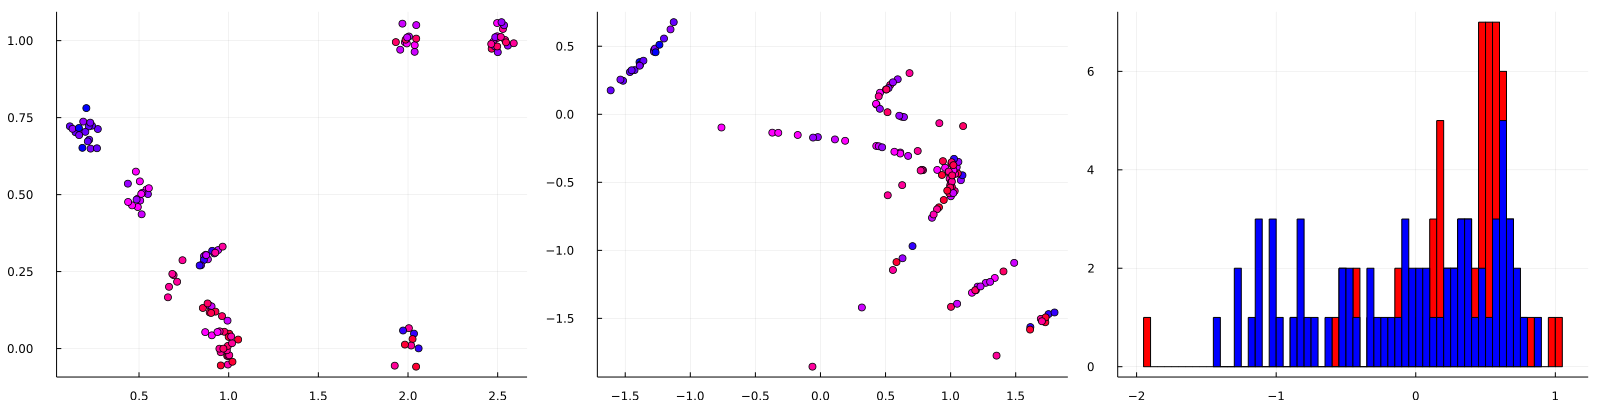

In [ ]:
params = Optim.minimizer(res_train)
cmap = colorsigned(color("blue"), color("magenta"), color("red")) ∘ scalesigned(0, 0.5, 1.0)
colors = cmap.(data_y)
inferred_model = deepcopy(compile(model, params))
trans_data_x_1 = hcat(map((x) -> forward(inferred_model, x), [data_x[k,:] for k=1:size(data_x,1)])...)'
trans_data_x_2 = map((x) -> dot([1, 1], x), [trans_data_x_1[k,:] for k=1:size(data_x,1)])
trans_data_x_2_split = [trans_data_x_2[data_y .>= 0.5], trans_data_x_2[data_y .<= 0.5]]
plt1 = scatter(data_x[:,1], data_x[:,2], color=colors)
plt2 = scatter(trans_data_x_1[:,1], trans_data_x_1[:,2], color=colors)
hist = histogram(trans_data_x_2_split; stacked=true, bins=60,  fillcolor=["red" "blue"], label = ["Positive" "Negative"], legend=:topleft)
plot(plt1, plt2, hist, size=(1600, 400), legend=false, layout=(1, 3))

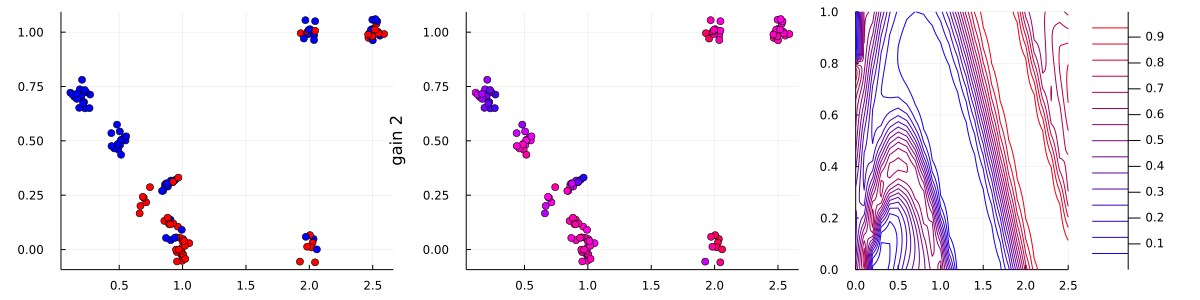

In [ ]:
using StatsFuns: normcdf
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:3, 0:0.01:1))))
im1 = scatter(data_x[:,1], data_x[:,2], xlabel="gain 1", ylabel="gain 2", color=dat_to_col(data_y))
im2 = scatter(data_x[:,1], data_x[:,2], xlabel="gain 1", ylabel="gain 2", color=cmap.(normcdf.(trans_data_x_2)))
im3 = contour(0.0:0.1:2.5, 0.0:0.01:1, (x, y) -> normcdf(dot([1, 1], forward(inferred_model, [x, y]))), color=["blue", "red"])
plot(im1, im2, im3, legend=false, layout=(1, 3), size=(1200, 300))

## Planning
Few things must be said about the planning stage. 
First of all, the idea of planning is a reverse problem to prefernce learning. 
Given the parameters of neural network, the goal prior for the appraisal (1.0) and an informative prior for the future context (we have an idea of how the environment evolves), we want to infer the most suitable gains.
The evolution of the context will be based on HMM model, where the observations are 

For illustration purposes, we will first run the inference algorithm to obtain **z** and **x**. Secondly, we run our agent that proposes gains.

In [ ]:
# test
mgs, covgs = repeat([0.5], 2), 1e-2*diagm(ones(2))
fe, gains = inference_flow_planner(mgs, covgs, 1.0, params)

(KeepActor{Real}(Real[1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183  …  1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183, 1.021442766356183]), Marginal(MvNormalWeightedMeanPrecision(
xi: [60.72392017235937, 59.41819271804103]
Λ: [102.57130818360082 2.258229791102371; 2.2582297911023708 101.98327132544716]
)
))

In [ ]:
test_files = get_sounds_fn("sound/AIDA/test/");

In [ ]:
# obtain HA output for test set (data for acting)
using JLD
# r for recovered
for test_file in test_files
    if !occursin(".wav", test_file)
        continue
    end
    
    speech, fs = WAV.wavread(test_file)
    speech_seg = get_frames(speech, fs)
    
    # choose priors
    # TODO: infer context
    if occursin("/babble/", test_file)
        priors_eta = (bblmη_arr, bblvη_arr)
        priors_tau = bblτ_arr
    elseif occursin("/train/", test_file)
        priors_eta = (trmη_arr, trvη_arr)
        priors_tau = trτ_arr
    else
        continue
    end
    println(test_file)
    
    # make sure that 1D of priors and speech_seg are equal
    if size(priors_eta, 1) != size(speech_seg, 1)
        totseg = size(speech_seg, 1)
        priors_eta_m, priors_eta_v, priors_tau = prior_to_priors(priors_eta[1][1, :]', priors_eta[2][1, :, :], priors_tau[1], totseg)
        priors_eta = priors_eta_m, priors_eta_v
    end
    rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe, rmo = HA_algorithm(speech_seg, priors_eta, priors_tau, 10, 2, 10);
    
    JLD.save("sound/AIDA/separated_jld/test/"*test_file[findfirst("sp", test_file)[1]:end][1:end-3]*"jld",
         "rmz", rmz, "rvz", rvz, "rmθ", rmθ, "rvθ", rvθ, "rγ", rγ, 
         "rmx", rmx, "rvx", rvx, "rmη", rmη, "rvη", rvη, "rτ", rτ,
         "fe", fe, "rmo", rmo, "filename", test_file,
         "audio", speech)
end

sound/AIDA/test/babble/0dB/sp21_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:05:27


sound/AIDA/test/babble/0dB/sp22_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:05


sound/AIDA/test/babble/0dB/sp23_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:35


sound/AIDA/test/babble/0dB/sp24_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:43


sound/AIDA/test/babble/0dB/sp25_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:19


sound/AIDA/test/babble/0dB/sp26_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:45


sound/AIDA/test/babble/0dB/sp27_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:35


sound/AIDA/test/babble/0dB/sp28_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:39


sound/AIDA/test/babble/0dB/sp29_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:02


sound/AIDA/test/babble/0dB/sp30_babble_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:44


sound/AIDA/test/train/0dB/sp21_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:05:13


sound/AIDA/test/train/0dB/sp22_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:32


sound/AIDA/test/train/0dB/sp23_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:36


sound/AIDA/test/train/0dB/sp24_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:37


sound/AIDA/test/train/0dB/sp25_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:04:05


sound/AIDA/test/train/0dB/sp26_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:19


sound/AIDA/test/train/0dB/sp27_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:18


sound/AIDA/test/train/0dB/sp28_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:09


sound/AIDA/test/train/0dB/sp29_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:30


sound/AIDA/test/train/0dB/sp30_train_sn0.wav


Progress: 100%|█████████████████████████████████████████| Time: 0:03:26


In [ ]:
test_jlds = get_sounds_fn("sound/AIDA/separated_jld/test/");

In [ ]:
shuffle!(test_jlds)

20-element Vector{Any}:
 "sound/AIDA/separated_jld/test/sp29_babble_sn0.jld"
 "sound/AIDA/separated_jld/test/sp21_babble_sn0.jld"
 "sound/AIDA/separated_jld/test/sp22_train_sn0.jld"
 "sound/AIDA/separated_jld/test/sp22_babble_sn0.jld"
 "sound/AIDA/separated_jld/test/sp26_train_sn0.jld"
 "sound/AIDA/separated_jld/test/sp28_train_sn0.jld"
 "sound/AIDA/separated_jld/test/sp25_train_sn0.jld"
 "sound/AIDA/separated_jld/test/sp28_babble_sn0.jld"
 "sound/AIDA/separated_jld/test/sp24_train_sn0.jld"
 "sound/AIDA/separated_jld/test/sp27_babble_sn0.jld"
 "sound/AIDA/separated_jld/test/sp30_babble_sn0.jld"
 "sound/AIDA/separated_jld/test/sp24_babble_sn0.jld"
 "sound/AIDA/separated_jld/test/sp21_train_sn0.jld"
 "sound/AIDA/separated_jld/test/sp23_train_sn0.jld"
 "sound/AIDA/separated_jld/test/sp30_train_sn0.jld"
 "sound/AIDA/separated_jld/test/sp26_babble_sn0.jld"
 "sound/AIDA/separated_jld/test/sp23_babble_sn0.jld"
 "sound/AIDA/separated_jld/test/sp27_train_sn0.jld"
 "sound/AIDA/separated_jld/test

In [ ]:
JLD.load(test_jlds[1])

Dict{String, Any} with 14 entries:
  "audio"    => [0.0357982; 0.0463576; … ; 0.0561846; 0.0305185]
  "rvz"      => [0.000636157 0.000395024 … 0.000352968 0.000392788; 0.00091129 …
  "rmz"      => [0.0141683 0.018576 … 0.0109912 0.00266901; 0.0142426 0.0120205…
  "rvθ"      => [0.00683489 -0.000595087 … 6.16575e-7 1.60723e-5; 0.00789193 -0…
  "rvη"      => [0.0154174 -0.00370245; 0.0148583 -0.00430479; … ; 0.0144886 -0…
  "rmη"      => [0.302686 -0.158365; 0.354431 -0.110905; … ; 0.341291 -0.018296…
  "rγ"       => [(41.0, 0.0207038), (41.0, 0.0238062), (41.0, 0.0174049), (41.0…
  "fe"       => [556.454 277.966 … -46.5285 -55.1719; 556.455 278.004 … -45.659…
  "rmo"      => [0.0363736 0.0465442 … 0.0300146 0.00859702; 0.0307284 0.026081…
  "rmx"      => [0.0222053 0.0279682 … 0.0190234 0.00592801; 0.0164858 0.014060…
  "rτ"       => [(81.0, 0.0786265), (81.0, 0.0810069), (81.0, 0.074315), (81.0,…
  "filename" => "sound/AIDA/test/train/0dB/sp21_train_sn0.wav"
  "rvx"      => [0.00067054

In [ ]:
active_dict = deepcopy(pl_dict)

Dict{Symbol, Vector{T} where T} with 3 entries:
  :appraisals => [0.6, 0.0, 0.0, 0.7, 0.0, 1.0, 0.5, 0.2, 0.0, 0.8  …  0.6, 0.1…
  :contexts   => [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0  …  0.0, 0.0…
  :gains      => [[0.2, 0.7], [0.2, 0.7], [0.2, 0.7], [0.2, 0.7], [0.2, 0.7], […

In [ ]:
# Here agent plans and learns
gs = [0.5, 0.5]
covgs = diageye(2)
context = 0.5
for test_jld in test_jlds
    d = JLD.load(test_jld)
    rmz, rmx = d["rmz"], d["rmx"]
    filename = d["filename"]
    # TODO: context inference
    if occursin("/babble/", filename)
        context = 1.0
        params = Optim.minimizer(res_babble)
        fe, gains = inference_flow_planner(gs, covgs, 1.0, params)
    elseif occursin("/train/", filename)
        context = 0.0
        params = Optim.minimizer(res_train)
        fe, gains = inference_flow_planner(gs, covgs, 1.0, params)
    else
        continue
    end
    rz, rx = get_signal(rmz, fs), get_signal(rmx, fs)
    # TODO change to the output of flow_nn
    gs = mean(gains)
    ha_out = gs[1] .* rz + gs[2] .* rx
    
    full_name = "sound/AIDA/planning/ha_out_$(gs[1])_$(gs[2])_"*filename[findfirst("sp", filename)[1]:end]
    WAV.wavwrite(ha_out, fs, full_name)
    WAV.wavplay(full_name)
    println("How's HA output 0..1 ?")
    appraisal = readline()
    
    # we can learn here as well. If the user provides a feedback to each proposal, we can feed this information back to our learning function.
    push!(active_dict[:appraisals], parse(Float64, appraisal))
    push!(active_dict[:gains], gs)
    push!(active_dict[:contexts], context)
end

How's HA output 0..1 ?


stdin>  0.2


How's HA output 0..1 ?


stdin>  0.0


How's HA output 0..1 ?


stdin>  0.0


How's HA output 0..1 ?


stdin>  0.2


How's HA output 0..1 ?


stdin>  0.0


How's HA output 0..1 ?


stdin>  0.2


How's HA output 0..1 ?


stdin>  0.1


How's HA output 0..1 ?


stdin>  0.1


How's HA output 0..1 ?


stdin>  0.0


How's HA output 0..1 ?


stdin>  0.7


How's HA output 0..1 ?


stdin>  0.8


How's HA output 0..1 ?


stdin>  0.5


How's HA output 0..1 ?


stdin>  0.3


How's HA output 0..1 ?


stdin>  0.4


How's HA output 0..1 ?


stdin>  0.4


How's HA output 0..1 ?


stdin>  0.4


How's HA output 0..1 ?


stdin>  0.1


How's HA output 0..1 ?


stdin>  0.2


How's HA output 0..1 ?


stdin>  0.1


How's HA output 0..1 ?


stdin>  0.1


In [ ]:
data_x, data_y = get_learning_data(active_dict, 0.0)
res_train = optimize(f, randn(12), LBFGS(), Optim.Options(store_trace = false, show_trace = true, f_tol=1e-10), autodiff=:forward);

Iter     Function value   Gradient norm 
     0     1.209474e+04     6.701012e+03
 * time: 0.00010085105895996094
     1     3.251034e+03     2.362342e+03
 * time: 0.32674694061279297
     2     4.804030e+02     4.138629e+02
 * time: 0.47789788246154785
     3     2.772470e+02     1.262527e+02
 * time: 0.6343679428100586
     4     2.525020e+02     1.375445e+02
 * time: 0.7901079654693604
     5     2.398343e+02     1.007449e+02
 * time: 0.9000217914581299
     6     2.303162e+02     6.324120e+01
 * time: 1.067605972290039
     7     2.241098e+02     1.563470e+02
 * time: 1.227712869644165
     8     1.785655e+02     1.891067e+02
 * time: 1.433762788772583
     9     1.742830e+02     1.427989e+02
 * time: 1.5871319770812988
    10     1.641674e+02     1.360540e+02
 * time: 1.7534849643707275
    11     1.611405e+02     6.436318e+01
 * time: 1.9063308238983154
    12     1.593350e+02     3.289795e+01
 * time: 2.1091527938842773
    13     1.570431e+02     4.289117e+01
 * time: 2.4023489

In [ ]:
data_x, data_y = get_learning_data(active_dict, 1.0)
res_babble = optimize(f, randn(12), LBFGS(), Optim.Options(store_trace = false, show_trace = true, f_tol=1e-10), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     1.896678e+04     8.453586e+03
 * time: 0.00014781951904296875
     1     3.031413e+03     8.696211e+03
 * time: 0.3738739490509033
     2     1.408799e+03     2.492577e+03
 * time: 0.6177668571472168
     3     5.303161e+02     8.336671e+02
 * time: 0.8022058010101318
     4     4.764814e+02     3.304571e+02
 * time: 0.9433548450469971
     5     3.480734e+02     3.894615e+02
 * time: 1.1286427974700928
     6     2.893697e+02     4.497519e+02
 * time: 1.2758409976959229
     7     2.449295e+02     1.305892e+02
 * time: 1.3842239379882812
     8     2.380654e+02     4.238580e+02
 * time: 1.4889748096466064
     9     2.165718e+02     2.677151e+02
 * time: 1.6860268115997314
    10     1.933184e+02     5.339142e+01
 * time: 1.8787009716033936
    11     1.878039e+02     8.013747e+01
 * time: 2.0669097900390625
    12     1.780145e+02     1.062218e+02
 * time: 2.22525691986084
    13     1.747833e+02     1.138836e+02
 * time: 2.42100477

 * Status: success

 * Candidate solution
    Final objective value:     1.195547e+02

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-10
    |g(x)|                 = 2.05e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   27  (vs limit Inf)
    Iterations:    63
    f(x) calls:    448
    ∇f(x) calls:   448


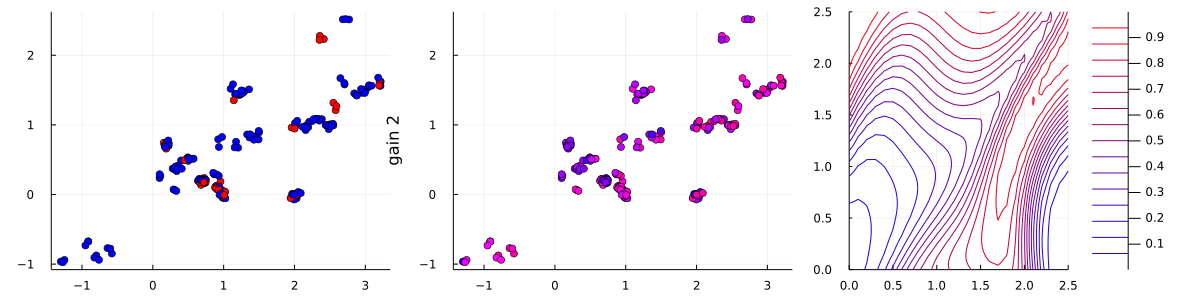

┌ Warning: Indices Base.OneTo(120) of attribute `seriescolor` does not match data indices 1:222.
└ @ Plots /Users/apodusenko/.julia/packages/Plots/Di0Qb/src/utils.jl:129
┌ Warning: Indices Base.OneTo(120) of attribute `linecolor` does not match data indices 1:222.
└ @ Plots /Users/apodusenko/.julia/packages/Plots/Di0Qb/src/utils.jl:129
┌ Warning: Indices Base.OneTo(120) of attribute `fillcolor` does not match data indices 1:222.
└ @ Plots /Users/apodusenko/.julia/packages/Plots/Di0Qb/src/utils.jl:129
┌ Warning: Indices Base.OneTo(120) of attribute `markercolor` does not match data indices 1:222.
└ @ Plots /Users/apodusenko/.julia/packages/Plots/Di0Qb/src/utils.jl:129
┌ Warning: Indices Base.OneTo(120) of attribute `seriescolor` does not match data indices 1:222.
└ @ Plots /Users/apodusenko/.julia/packages/Plots/Di0Qb/src/utils.jl:129
┌ Warning: Indices Base.OneTo(120) of attribute `linecolor` does not match data indices 1:222.
└ @ Plots /Users/apodusenko/.julia/packages/Plots/Di0Qb/src

In [ ]:
using StatsFuns: normcdf
data_x, data_y = get_learning_data(active_dict, 0.0)
params = Optim.minimizer(res_train)
inferred_model = deepcopy(compile(model, params))
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:3, 0:0.01:1))))
im1 = scatter(data_x[:,1], data_x[:,2], xlabel="gain 1", ylabel="gain 2", color=dat_to_col(data_y))
im2 = scatter(data_x[:,1], data_x[:,2], xlabel="gain 1", ylabel="gain 2", color=cmap.(normcdf.(trans_data_x_2)))
im3 = contour(0.0:0.1:2.5, 0.0:0.01:2.5, (x, y) -> normcdf(dot([1, 1], forward(inferred_model, [x, y]))), color=["blue", "red"])
plot(im1, im2, im3, legend=false, layout=(1, 3), size=(1200, 300))